In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import leastsq
#from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline
import os.path 
 

* Semana — Week number (From Thursday to Wednesday)
* Agencia_ID — Sales Depot ID
* Canal_ID — Sales Channel ID
* Ruta_SAK — Route ID (Several routes = Sales Depot)
* Cliente_ID — Client ID
* NombreCliente — Client name
* Producto_ID — Product ID
* NombreProducto — Product Name
* Venta_uni_hoy — Sales unit this week (integer)
* Venta_hoy — Sales this week (unit: pesos)
* Dev_uni_proxima — Returns unit next week (integer)
* Dev_proxima — Returns next week (unit: pesos)
* Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)

In [2]:
dtype_dict = { 'Semana' : int, 'Agencia_ID' : int, 'Canal_ID' : int, 'Ruta_SAK' : int, 'Cliente_ID' : int,
               'NombreCliente' : str, 'Producto_ID' : int, 'NombreProducto' : str, 'Venta_uni_hoy' : int,
               'Venta_hoy' : float, 'Dev_uni_proxima' : int, 'Dev_proxima' : float, 'Demanda_uni_equil' : int}

train_cols = ['Cliente_ID', 'Producto_ID', 'Ruta_SAK', 'Agencia_ID', 'Canal_ID', 'Demanda_uni_equil']
target = 'Demanda_uni_equil'
output_folder = 'output/median/'

In [3]:
data = pd.read_csv('input/train.csv', dtype = dtype_dict, usecols = train_cols)
data.head()

,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,1110,7,3301,15766,1212,3
1,1110,7,3301,15766,1216,4
2,1110,7,3301,15766,1238,4
3,1110,7,3301,15766,1240,4
4,1110,7,3301,15766,1242,3


In [4]:
#data.loc[data[target] == 0, target] = 1e-6

In [5]:
#data[target] = np.log(data[target])

In [4]:
train = data

In [7]:
train.describe()

,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
count,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07
mean,2.536509e+03,1.383181e+00,2.114855e+03,1.802119e+06,2.084081e+04,7.224564e+00
std,4.075124e+03,1.463266e+00,1.487744e+03,2.349577e+06,1.866392e+04,2.177119e+01
min,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00
25%,1.312000e+03,1.000000e+00,1.161000e+03,3.567670e+05,1.242000e+03,2.000000e+00
50%,1.613000e+03,1.000000e+00,1.286000e+03,1.193385e+06,3.054900e+04,3.000000e+00
75%,2.036000e+03,1.000000e+00,2.802000e+03,2.371091e+06,3.742600e+04,6.000000e+00
max,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,5.000000e+03


## Build features for train data 

In [5]:
feature_full_list = ['12345a',
                     '1234a 5a', '1235a 4a', '1245a 3a', '1345a 2a', '2345a 1a',
                     '123a 45a', '124a 35a', '125a 34a', '134a 25a', '135a 24a', '145a 23a',
                     '234a 15a', '235a 14a', '245a 13a', '345a 12a',
                     '123a 4a 5a', '124a 3a 5a', '125a 3a 4a', '134a 2a 5a', '135a 2a 4a', '145a 2a 3a',
                     '234a 1a 5a', '235a 1a 4a', '245a 1a 3a', '345a 1a 2a',
                     '12a 34a 5a', '12a 35a 4a', '12a 45a 3a', '13a 24a 5a', '13a 25a 4a', '13a 45a 2a',
                     '14a 23a 5a', '14a 25a 3a', '14a 35a 2a', '15a 23a 4a', '15a 24a 3a', '15a 34a 2a',
                     '23a 45a 1a', '24a 35a 1a', '25a 34a 1a', 
                     '12a 3a 4a 5a', '13a 2a 4a 5a', '14a 2a 3a 5a', '15a 2a 3a 4a',
                     '23a 1a 4a 5a', '24a 1a 3a 5a', '25a 1a 3a 4a', '34a 1a 2a 5a',
                     '35a 1a 2a 4a', '45a 1a 2a 3a',
                     '1a 2a 3a 4a 5a',
                     
                     #non existing products
                     '1345a',
                     '134a 5a', '135a 4a', '145a 3a', '345a 1a', 
                     '13a 45a', '14a 35a', '15a 34a',
                     '13a 4a 5a', '14a 3a 5a', '15a 3a 4a', '34a 1a 5a', '35a 1a 4a', '45a 1a 3a',
                     '1a 3a 4a 5a',
                     
                     '1234a', '1235a', '1245a', '1345a', '2345a', '123a', '124a', '125a', '134a', '135a', '145a',
                     '234a', '235a', '245a', '345a', '12a', '13a', '14a', '15a', '23a', '24a', '25a', '34a', '35a', '45a',
                     '1a', '2a', '3a', '4a', '5a'
                    ]

In [6]:
feature_full_list = ['12345a', '1245a 3a', '1245a', '1234a 5a', '1234a', '1235a 4a', '1235a', 
                           '124a 35a', '124a 3a 5a', '124a', '125a 34a', '125a 3a 4a', '125a',
                           '123a 45a', '123a 4a 5a', '123a',
                           '345a 12a', '12a 45a 3a', '12a 34a 5a', '12a 35a 4a', '12a 3a 4a 5a', '12a',
                           '2345a 1345a', '2345a 145a', '2345a 134a', '2345a 135a',
                           '2345a 14a', '2345a 15a', '2345a 13a', '2345a 1a', '2345a',
                           '245a 1a 3a', '245a 13a',  '245a', '14a 25a 3a', '24a 1a 3a 5a', '15a 24a 3a', '13a 24a 5a',
                           '234a 1a 5a', '235a 14a', '24a 35a 1a', '25a 1a 3a 4a', '235a 1a 4a', '134a 25a', '234a 15a',
                           '135a 24a', '13a 25a 4a', '25a 34a 1a', '14a 23a 5a', '145a 23a', '15a 23a 4a', '234a',
                           '24a', '23a 1a 4a 5a', '145a 2a 3a', '235a', '14a 2a 3a 5a', '134a 2a 5a', '14a 35a 2a',
                           '1345a 2a', '23a 45a 1a', '15a 2a 3a 4a', '135a 2a 4a', '25a', '15a 34a 2a', '45a 1a 2a 3a',
                           '1a 2a 3a 4a 5a', '13a 2a 4a 5a', '34a 1a 2a 5a', '13a 45a 2a', '345a 1a 2a', '35a 1a 2a 4a',
                           '1345a', '145a 3a', '145a', '14a 3a 5a', '134a 5a', '14a 35a',
                           '134a', '14a', '23a', '135a 4a', '135a', '15a 34a', '15a 3a 4a', '15a', '45a 1a 3a',
                           '13a 45a', '345a 1a', '1a 3a 4a 5a', '13a 4a 5a', '34a 1a 5a', '13a', '35a 1a 4a',
                           '1a', '2a', '345a', '45a', '35a', '34a', '4a', '5a', '3a']

In [7]:
for i in range(0, len(feature_full_list)):
    feature_full_list[i] = feature_full_list[i].replace('a', '')
#feature_full_list    

In [8]:
def get_cols(feature):
    res = []
    feature_dict = {}
    feature_dict['1'] = 'Cliente_ID'  
    feature_dict['2'] = 'Producto_ID' 
    feature_dict['3'] = 'Canal_ID'    
    feature_dict['4'] = 'Ruta_SAK'    
    feature_dict['5'] = 'Agencia_ID'  
    feature_dict['6'] = 'Semana'      
    for i in str(feature):
        if i in '123456':
            res.append(feature_dict[i])
    
    return res

In [9]:
def build_sub_feature(data, target, sub_feature, folder):
    fname = folder + str(sub_feature)+'.csv'
    
    if not(os.path.isfile(fname)):
        groupby = get_cols(sub_feature)
        #( pd.DataFrame( { feature : float(data.groupby(by = groupby)[target].agg( lambda x: x.mode()) 
        #            ) } ).reset_index() ).to_csv(fname)
        #pd.Series.mode
        #df.groupby('B').agg(lambda x: scipy.stats.mode(x)[0])
        if sub_feature[-1] == 'a':
            ( pd.DataFrame({ sub_feature : data.groupby(by = groupby)[target].mean() }).reset_index() ).to_csv(fname)
        else:    
            ( pd.DataFrame({ sub_feature : data.groupby(by = groupby)[target].median() }).reset_index() ).to_csv(fname)
        return True
    else:
        return False

def build_all_features(data, target, features, folder):
    for feature in features:
        res = ''
        for sub_feature in feature.split():
            res = res + sub_feature + ' '
            if build_sub_feature(data, target, sub_feature, folder):
                 res = res + '(created)  '
        print res
            
    return 'Done'
   

In [10]:
def merge_new_feature(data, feature, folder):
    for sub_feature in feature.split():
        groupby = get_cols(sub_feature)
        f = pd.read_csv(folder + str(sub_feature)+'.csv', dtype = float )
        f.drop(f.columns[[0]], axis=1, inplace=True)
        data = pd.merge(data, f, how='left', on = groupby)
        
    return data

In [11]:
def train_feature(data, target, feature, folder):
    outF = open(folder + "train.txt", "a")
    print 'Merge ', feature 
    data = merge_new_feature(data, feature, folder)
    H = pd.DataFrame()
    sub_feature_list = feature.split()
    
    for i in range(0, len(sub_feature_list)):
        H[i] = data[sub_feature_list[i]]
    y = data[target]

    print 'Train...'
    model = linear_model.LinearRegression()
    model.fit(H, y)
    mRSS = mean_squared_error(model.predict(H),y)
    
    for i in range(0, len(sub_feature_list)):
        del data[sub_feature_list[i]]
    
    w = [model.intercept_]
    for i in range(0, len(sub_feature_list)):
        w.append(model.coef_[i])
    w.append(mRSS)

    res = { feature: w}   
    print res    
    print >>outF, res
    outF.close()
    
    return res

#print train_feature(train, target, feature='2a 3a', folder = output_folder)

In [12]:
def train_all_features(data, target, features,  folder):
    
    features_trained = {}
    for feature in features:
        features_trained.update( train_feature(data, target, feature, folder) )
    return features_trained

In [14]:
train.loc[train[target] == 0, target] = 1e-3
train[target] = np.log(train[target])

In [15]:
train.describe()

,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
count,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07
mean,2.536509e+03,1.383181e+00,2.114855e+03,1.802119e+06,2.084081e+04,1.173570e+00
std,4.075124e+03,1.463266e+00,1.487744e+03,2.349577e+06,1.866392e+04,1.478986e+00
min,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,-6.907755e+00
25%,1.312000e+03,1.000000e+00,1.161000e+03,3.567670e+05,1.242000e+03,6.931472e-01
50%,1.613000e+03,1.000000e+00,1.286000e+03,1.193385e+06,3.054900e+04,1.098612e+00
75%,2.036000e+03,1.000000e+00,2.802000e+03,2.371091e+06,3.742600e+04,1.791759e+00
max,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,8.517193e+00


In [16]:
output_folder = 'output/log/'

In [17]:
feature_full_list = ['12345a', '1245a 3a', '1245a', '1234a 5a', '1234a', '1235a 4a', '1235a', 
                           '124a 35a', '124a 3a 5a', '124a', '125a 34a', '125a 3a 4a', '125a',
                           '123a 45a', '123a 4a 5a', '123a',
                           '345a 12a', '12a 45a 3a', '12a 34a 5a', '12a 35a 4a', '12a 3a 4a 5a', '12a',
                           '2345a 1345a', '2345a 145a', '2345a 134a', '2345a 135a',
                           '2345a 14a', '2345a 15a', '2345a 13a', '2345a 1a', '2345a',
                           '245a 1a 3a', '245a 13a',  '245a', '14a 25a 3a', '24a 1a 3a 5a', '15a 24a 3a', '13a 24a 5a',
                           '234a 1a 5a', '235a 14a', '24a 35a 1a', '25a 1a 3a 4a', '235a 1a 4a', '134a 25a', '234a 15a',
                           '135a 24a', '13a 25a 4a', '25a 34a 1a', '14a 23a 5a', '145a 23a', '15a 23a 4a', '234a',
                           '24a', '23a 1a 4a 5a', '145a 2a 3a', '235a', '14a 2a 3a 5a', '134a 2a 5a', '14a 35a 2a',
                           '1345a 2a', '23a 45a 1a', '15a 2a 3a 4a', '135a 2a 4a', '25a', '15a 34a 2a', '45a 1a 2a 3a',
                           '1a 2a 3a 4a 5a', '13a 2a 4a 5a', '34a 1a 2a 5a', '13a 45a 2a', '345a 1a 2a', '35a 1a 2a 4a',
                           '1345a', '145a 3a', '145a', '14a 3a 5a', '134a 5a', '14a 35a',
                           '134a', '14a', '23a', '135a 4a', '135a', '15a 34a', '15a 3a 4a', '15a', '45a 1a 3a',
                           '13a 45a', '345a 1a', '1a 3a 4a 5a', '13a 4a 5a', '34a 1a 5a', '13a', '35a 1a 4a',
                           '1a', '2a', '345a', '45a', '35a', '34a', '4a', '5a', '3a']

In [ ]:
build_all_features(train, target, feature_full_list, folder = output_folder)

12345a (created)  


In [ ]:
features_trained = train_all_features(train, target, feature_full_list, folder = output_folder)
print features_trained

In [ ]:
for i in range(0, len(feature_full_list)):
    feature_full_list[i] = feature_full_list[i].replace('a', '')

In [ ]:
build_all_features(train, target, feature_full_list, folder = output_folder)

In [ ]:
features_trained = train_all_features(train, target, feature_full_list, folder = output_folder)
print features_trained

In [6]:
features_trained_sorted = ['12345a', '1245a 3a', '1245a', '124a 3a 5a', '1234a 5a', '124a 35a', '1234a', '124a', '1235a 4a', '1235a', '125a 34a', '125a 3a 4a', '125a', '123a 45a', '123a 4a 5a', '123a', '12a 45a 3a', '345a 12a', '12a 3a 4a 5a', '12a 34a 5a', '12a 35a 4a', '12a', '245a 1a 3a', '245a 13a', '2345a 1a', '2345a', '245a', '14a 25a 3a', '24a 1a 3a 5a', '15a 24a 3a', '13a 24a 5a', '234a 1a 5a', '235a 14a', '24a 35a 1a', '25a 1a 3a 4a', '235a 1a 4a', '134a 25a', '234a 15a', '135a 24a', '13a 25a 4a', '25a 34a 1a', '14a 23a 5a', '145a 23a', '15a 23a 4a', '234a', '24a', '23a 1a 4a 5a', '145a 2a 3a', '235a', '14a 2a 3a 5a', '134a 2a 5a', '14a 35a 2a', '1345a 2a', '23a 45a 1a', '15a 2a 3a 4a', '135a 2a 4a', '25a', '15a 34a 2a', '45a 1a 2a 3a', '1a 2a 3a 4a 5a', '13a 2a 4a 5a', '34a 1a 2a 5a', '13a 45a 2a', '345a 1a 2a', '35a 1a 2a 4a', '1345a', '145a 3a', '145a', '14a 3a 5a', '134a 5a', '14a 35a', '134a', '14a', '23a', '135a 4a', '135a', '15a 34a', '15a 3a 4a', '15a', '45a 1a 3a', '13a 45a', '345a 1a', '1a 3a 4a 5a', '13a 4a 5a', '34a 1a 5a', '13a', '35a 1a 4a', '1a', '2a', '345a', '45a', '35a', '34a', '4a', '5a', '3a']

In [6]:
def describe_feature(feature, folder):
    if 'a' in feature:
        feature_ = feature#[:-1]
    else:
        feature_ = feature
    f = pd.read_csv(folder + str(feature)+'.csv', dtype = float)
    print f[feature_].describe()
    plt.hist(f[feature_])
    print f.head()
    print f.tail()

count      9.000000
mean      43.722890
std       44.661479
min        5.733601
25%       12.613418
50%       15.271449
75%       61.208581
max      136.412912
Name: 3a, dtype: float64
   Unnamed: 0  Canal_ID          3a
0         0.0       1.0    5.733601
1         1.0       2.0   61.208581
2         2.0       4.0   12.365865
3         3.0       5.0  136.412912
4         4.0       6.0   12.613418
   Unnamed: 0  Canal_ID         3a
4         4.0       6.0  12.613418
5         5.0       7.0  15.271449
6         6.0       8.0  46.431238
7         7.0       9.0  88.616402
8         8.0      11.0  14.852548


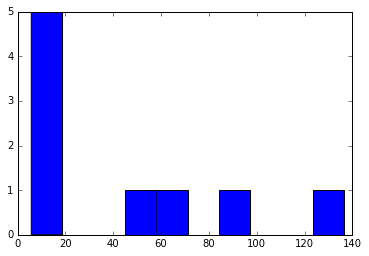

In [7]:
describe_feature('3a', 'output/median/')

count    2.639314e+07
mean     5.606105e+00
std      1.619781e+01
min      0.000000e+00
25%      1.800000e+00
50%      3.000000e+00
75%      5.333333e+00
max      5.000000e+03
Name: 1245a, dtype: float64
   Unnamed: 0  Cliente_ID  Producto_ID  Ruta_SAK  Agencia_ID  1245a
0         0.0        26.0       1182.0    7212.0      2061.0   13.0
1         1.0        26.0       4767.0    7212.0      2061.0   42.0
2         2.0        26.0      30235.0    4189.0      2655.0   96.0
3         3.0        26.0      30314.0    4189.0      2655.0   48.0
4         4.0        26.0      31393.0    7212.0      2061.0   17.0
          Unnamed: 0    Cliente_ID  Producto_ID  Ruta_SAK  Agencia_ID  1245a
26393136  26393136.0  2.015152e+09       2665.0     900.0     22362.0    7.0
26393137  26393137.0  2.015152e+09       3270.0     900.0     22362.0   14.0
26393138  26393138.0  2.015152e+09       4270.0     900.0     22362.0   10.0
26393139  26393139.0  2.015152e+09       4280.0     900.0     22362.0    6.0
263

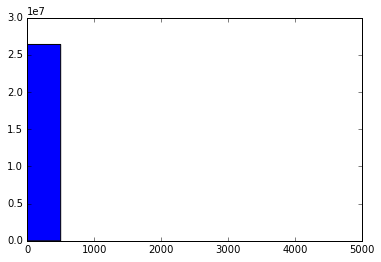

In [8]:
describe_feature('1245a', 'output/median/')

In [ ]:
def evaluate_features(data, target, features, folder):
    feature_evaluation_list = {}
    print 'Start'
    for feature in features:
        data = merge_new_features(data, [feature], folder)
        e = data[target] - data[feature]
        del data[feature]
        #e = e[pd.notnull(e)]
        feature_evaluation_list[feature] = np.dot(e, e) / len(e) 
        print feature, ' : ', feature_evaluation_list[feature]
    
    print 'Done'
    
    return feature_evaluation_list

## Median

## Mean

In [8]:
features_trained = {'13a 45a': [-0.82842964314149459, 0.81826841851313659, 0.2964000435152635, 299.91773414618734], '23a 1a 4a 5a': [-0.79274640340401259, 0.81501826480191664, 0.80266968219105261, 0.070507571202941197, -0.57846621093423367, 228.86776784817377], '34a 1a 5a': [-0.42266829348379176, 0.34261804064580909, 0.93488315251966214, -0.21899686082627656, 304.06616901384916], '15a 23a 4a': [-0.99334355367226213, 0.81704652146106183, 0.76700098382810245, -0.44655221101955817, 221.0664036461994], '2345a 1a': [-1.3930592672202602, 0.87452622782074518, 0.31829637939634059, 131.97828986051962], '235a 1a 4a': [-0.92867480139842851, 0.83507570616202098, 0.62793692984968674, -0.33446857426490662, 195.03878560648542], '345a 1a 2a': [-3.4511122161912651, 0.15303825780711433, 0.67393213426599985, 0.65072102492771189, 253.96684701302669], '135a 24a': [-1.8752651860006528, 0.50268232402698765, 0.75688561460749837, 196.29754710573329], '1a 3a 4a 5a': [-0.20977823877367374, 0.95499057414779054, -0.50437292312091242, 0.42735706401783979, 0.15106208754484671, 303.07020533327631], '12a 3a 4a 5a': [-0.02365289673223625, 0.99709985825337311, -0.087510343040835908, 0.021608570290960017, 0.072075869398107784, 70.039637117315408], '125a 34a': [-0.10589309805211222, 0.99592676972848182, 0.018730598937132883, 61.187949576411754], '245a 13a': [-1.3989452187857987, 0.87188098840477546, 0.32175633255315933, 131.62349389379642], '24a 35a 1a': [-0.79568808153549586, 0.85557502745352687, -0.39240564170929471, 0.64696709877121072, 191.44897721350364], '1245a 3a': [0.0001830362199841673, 1.0000051944680164, -3.052972975600567e-05, 50.595456611298971], '134a 2a 5a': [-2.1479189815709008, 0.88478066716383397, 0.68137720267706003, -0.26885010421812428, 233.37869633393854], '145a 3a': [0.00021052120571507515, 1.0000173244490789, -4.6464090666702581e-05, 280.77993407772971], '345a 1a': [-0.85312774642860045, 0.30795346409587188, 0.81013362683166878, 301.54653125909687], '12a 45a 3a': [-0.0015499422521241257, 0.98640401904094188, 0.10178325960573156, -0.087972740821100348, 69.6699359459314], '123a 45a': [-0.2472861028952007, 0.98621205641685572, 0.048016459347550826, 68.543597825679512], '245a 1a 3a': [-0.0045885946611727846, 0.89873781522117813, 0.44883161811368871, -0.34693429540005638, 127.17396226363084], '1345a 2a': [-3.0696431975717475, 0.79233367949361055, 0.63255607107875467, 234.37770398690441], '23a 45a 1a': [-2.3943806267656997, 0.69745246714574471, 0.011789827985464754, 0.62217986757722543, 239.2181344927566], '15a 34a 2a': [-2.528416104724406, 0.86510526106079488, -0.19377874347388924, 0.67864838794259863, 242.21972383592089], '25a 34a 1a': [-1.1984533878433625, 0.83057980352270877, -0.33314423277604377, 0.66845034115232538, 199.81813929090382], '1234a 5a': [-0.069551522578528591, 0.99772579905634018, 0.011901290210482843, 61.109856751732451], '235a 14a': [-2.0585875978196713, 0.73418060408120456, 0.55076221000908043, 191.29595225790311], '13a 45a 2a': [-3.4305989325773796, 0.68457035694947088, 0.14047562994788326, 0.64980604995498514, 252.43817146054846], '35a 1a 2a 4a': [-2.8654029866831978, -0.096107021231253795, 0.80189806895284288, 0.68288963467115826, 0.0079388208981996181, 254.88280908735285], '345a 12a': [-0.25716226833705136, 0.049973209456649674, 0.98562233211535577, 69.893992090488013], '15a 34a': [-0.17664066642397458, 0.97644311559716057, 0.048006894996000561, 292.86261598511311], '14a 23a 5a': [-0.6040130997573252, 0.83736053399930022, 0.79065942367315212, -0.54441448342656484, 210.86066398311138], '15a 2a 3a 4a': [-1.988146135419524, 0.87867455905455127, 0.70817285185485901, -0.40480508121690617, 0.093150212635481899, 239.44924863943203], '12a 34a 5a': [-0.10064939020031716, 0.99538370576733926, 0.037757063275500644, -0.019209216890029572, 70.066402209516397], '124a 35a': [-0.05966399197829908, 0.99763601328073781, 0.010622477051254674, 61.117763930541109], '14a 25a 3a': [-0.10483711905492754, 0.72258244752176182, 0.81204429071579043, -0.5201155346549744, 185.01509001721399], '1345a': [-8.1001871876651421e-13, 1.0000000000001139, 280.7739496817556], '123a 4a 5a': [-0.069426393765932737, 0.99777097132103243, -0.007077746158545087, 0.018916544192367518, 68.732166339473011], '14a 3a 5a': [-0.01741173852452782, 0.99325510908438752, -0.085719870029587114, 0.094874835589892154, 283.0833814961033], '14a 2a 3a 5a': [-1.9032306891633501, 0.89096356100662799, 0.69177940363856227, -0.32200707778943005, 0.0027029432466311467, 232.34483292831828], '13a 25a 4a': [-1.0658249457274396, 0.66298473687766202, 0.82357123101761087, -0.33902804161952343, 198.98462495841892], '45a 1a 2a 3a': [-1.9885270676463849, 0.441366492339137, 0.74199622251115394, 0.72006049946176343, -0.62817794461851273, 243.60813099234659], '34a 1a 2a 5a': [-2.4684291716804525, 0.24867322975585177, 0.8340102747483078, 0.70128616948037892, -0.44229795920978732, 251.3417502501992], '12345a': [2.0044410575792426e-11, 0.99999999999722378, 50.588550852918992], '13a 2a 4a 5a': [-2.5045230121692219, 0.84707158578814901, 0.70261084045799305, 0.19098737503626997, -0.39400209775735689, 250.10825105827047], '134a 5a': [-0.090908592715845948, 0.99117609129132189, 0.021407172234062865, 283.15187770155705], '25a 1a 3a 4a': [-0.18277171268867676, 0.85591586201170056, 0.72990009963381297, -0.7207482070076745, 0.16023089488516107, 191.85321891007777], '124a 3a 5a': [-0.01275365630222236, 0.99822563906715567, -0.066112842184158666, 0.069652521590956334, 61.07225042545344], '14a 35a 2a': [-2.3787917628466007, 0.88722228469048547, -0.2284910286651412, 0.67053314824774202, 234.1530293957683], '145a 2a 3a': [-1.8991091768457169, 0.89276547443865117, 0.69046372055558669, -0.32036085084995958, 230.13545069411475], '14a 35a': [-0.082273272793401908, 0.989489311200762, 0.021898680206071053, 283.15616222314839], '15a 3a 4a': [-0.030691365762939959, 0.99068587299418265, -0.055181312844572235, 0.068743636107880146, 292.88982771683698], '135a 4a': [-0.1000788942498172, 0.98847396713202529, 0.02537861887830712, 292.57577755035135], '13a 24a 5a': [-0.52211429453746039, 0.65209671083326826, 0.83933257266212502, -0.41915996810654366, 190.30516402495016], '234a 15a': [-1.8651354399331899, 0.75905923549310106, 0.49910657755122917, 195.82212378807131], '24a 1a 3a 5a': [-0.038308056689879244, 0.85924915080444575, 0.6694751540297097, -0.58452050320024418, 0.061098671521546938, 187.66800959004865], '145a 23a': [-2.44085658163094, 0.6821341132270663, 0.65572109579949256, 220.51255995081863], '135a 2a 4a': [-2.4229044904691284, 0.86474066673657513, 0.67827647092352383, -0.207646797084241, 241.7137573615264], '13a 4a 5a': [-0.47222234683236142, 0.95049839452782114, 0.26709096071870009, -0.15222591648615053, 303.10577256367435], '35a 1a 4a': [-0.71490360833046918, 0.083578668912353687, 0.91048151223958507, 0.10489438661915912, 305.40295897217209], '125a 3a 4a': [-0.0063809545562083514, 0.9993084294164557, -0.013748747621321784, 0.015323548605045248, 61.208693377382225], '234a 1a 5a': [-0.51577984523805842, 0.84386404857413455, 0.64781073137160161, -0.42028225785487133, 190.46195084281794], '15a 24a 3a': [-0.021031372427986028, 0.64267824183698974, 0.82529676721247769, -0.46506391677916836, 187.78417457623038], '1235a 4a': [-0.024165923719988491, 0.99915481143746465, 0.0041901549449033714, 61.174716931198866], '1a 2a 3a 4a 5a': [-2.168062123610313, 0.85065642379722639, 0.72079070704618375, -0.73340789442239929, 0.41943521930884831, 0.042621456281953365, 247.70783667909143], '134a 25a': [-2.1750977566258891, 0.57833310393494353, 0.7227366568810929, 195.80635150613213], '45a 1a 3a': [-0.0089698350048772468, 0.45588053993788513, 0.85021443202533209, -0.30485339738506934, 298.98052738514667], '12a 35a 4a': [-0.065984391069040527, 0.99691183837191688, 0.027250953434140711, -0.015029452958991704, 70.089728613061837]}
features_trained.update( {'12a': [-7.5406347832540632e-12, 1.0000000000010474, 70.111559238072701], '13a': [-3.2027713814386516e-12, 1.0000000000005507, 304.92486991292816], '1235a': [-6.198597191087174e-12, 1.0000000000008589, 61.175888905409302], '24a': [-1.1732836924238654e-12, 1.0000000000001739, 227.56570087793841], '2345a': [4.6629367034256575e-13, 0.99999999999993616, 143.70033786172652], '25a': [-1.4157564010019996e-12, 1.0000000000001947, 241.77579187902441], '23a': [7.5299766422176617e-12, 0.99999999999907541, 288.41718774267838], '45a': [5.7553961596568115e-13, 0.99999999999992228, 353.43603195044005], '15a': [-1.8163248682867561e-12, 1.0000000000002587, 292.9721306198166], '123a': [2.6350477355663315e-11, 0.99999999999635603, 68.744493598719743], '14a': [-2.2657431486550195e-12, 1.00000000000032, 283.17951211921786], '134a': [-4.4586556668946287e-13, 1.0000000000000682, 283.17352762571443], '135a': [3.2329694477084558e-13, 0.99999999999996159, 292.60549165182766], '245a': [1.4477308241112041e-13, 0.99999999999998102, 143.70440637769059], '34a': [-2.9570124127076269e-11, 1.0000000000040734, 382.88104746372107], '124a': [1.2424727913185052e-11, 0.9999999999982786, 61.125910698280229], '145a': [3.5171865420124959e-13, 0.99999999999995337, 280.77993417525892], '35a': [-3.7283953702171857e-11, 1.0000000000051967, 381.33791585693018], '125a': [9.4972918418534391e-12, 0.99999999999868527, 61.213063623709722], '1234a': [1.0088818669373723e-11, 0.99999999999860123, 61.11900488418285], '235a': [-3.1938895972416503e-12, 1.0000000000004532, 232.08179350189417], '1a': [-3.2738256550146616e-12, 1.0000000000005604, 306.9578344073995], '345a': [4.2064129956997931e-12, 0.99999999999942002, 353.43378369461283], '234a': [-1.0933476346508542e-12, 1.0000000000001639, 226.54949558746802], '2a': [-2.3137047833188262e-12, 1.0000000000001685, 337.20701743250805], '1245a': [3.4950708993619628e-11, 0.99999999999516131, 50.595456667016528], '3a': [-4.4508574603696616e-10, 1.0000000000617049, 401.94918626016425], '4a': [-2.6508573114369938e-11, 1.0000000000036993, 390.43819401410349], '5a': [-4.4454218084410968e-11, 1.0000000000061784, 394.3222130822432], '1345a': [-8.1001871876651421e-13, 1.0000000000001139, 280.7739496817556]} )

features_trained.update({'2345a 1345a': [-1.3277944775346233, 0.84486504344371904, 0.33892382974436502, 129.4552355860161], '2345a 134a': [-1.3380159929197299, 0.84756184676235979, 0.33764185441807565, 129.62241279114502], '2345a 135a': [-1.3043951042114665, 0.86151647412005339, 0.31903353602926193, 131.57320611112812], '2345a 13a': [-1.398886401528773, 0.87188608670350032, 0.32174309296632403, 131.62050102712641], '2345a 14a': [-1.3379848915619528, 0.84757142197143254, 0.33762797426302127, 129.6239192709875], '2345a 15a': [-1.3054680171642206, 0.86191973125672705, 0.31877878791710373, 131.60309930149302], '2345a 145a': [-1.3277640137959219, 0.84487472727980761, 0.33890992921939606, 129.4567511020937]} )

## Mean Log